In [2]:
import torch

print(torch.version.cuda)
print(torch.cuda.get_device_name(0))

12.8
NVIDIA GeForce RTX 4060 Laptop GPU


In [1]:
import torch

# Check and report VRAM usage
# torch.cuda.memory_allocated() gives the current tensor memory usage in bytes.
allocated_bytes = torch.cuda.memory_allocated('cuda')
allocated_mb = allocated_bytes / (1024 * 1024)

reserved_bytes = torch.cuda.memory_reserved('cuda')
reserved_mb = reserved_bytes / (1024 * 1024)

print("\n--- VRAM USAGE REPORT ---")
print(f"Memory Allocated: {allocated_mb:.2f} MB")
print(f"Memory Reserved:  {reserved_mb:.2f} MB")
print("-------------------------\n")
#


--- VRAM USAGE REPORT ---
Memory Allocated: 0.00 MB
Memory Reserved:  0.00 MB
-------------------------



In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

training_pipeline = A.Compose([
    A.Resize(height=224, width=224),
    A.SquareSymmetry(p=0.5),
    A.RandomCrop(height=180, width=180,  p=1.0),
    A.Resize(height=224, width=224),
    A.RandomRain(slant_range=(-15,15), drop_length=15, drop_width=1, rain_type="default", blur_value=7 ,p=0.3),
    A.RandomBrightnessContrast(brightness_limit=(-0.3, 0.3), contrast_limit=(-0.2, 0.2), p=0.3),
    A.Rotate(limit=45, p=0.4),
    A.GaussNoise(std_range=(0.1, 0.2), per_channel=True  ,p=0.5),
    A.ColorJitter(brightness=(0.8, 1.1), contrast=(0.8, 1.1), saturation=(0.8, 1.1), hue=(-0.5, 0.5)),
    A.OneOf([
        A.CoarseDropout(num_holes_range=(1, 8), hole_height_range=(0.1, 0.25),
                        hole_width_range=(0.1, 0.25), fill=0, p=0.5),
        A.GridDropout(ratio=0.5, random_offset=True,  p=0.5)
    ]),
    A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

validation_pipeline = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [4]:
import cv2
from torchvision import datasets

class CustomDataset(datasets.ImageFolder):

    def __getitem__(self, index):

        path, target = self.samples[index]

        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, target

    def __len__(self):
        return len(self.samples)

In [5]:
import torchvision.models as models
import torch.nn as nn

class PestClassifierMobileNetV2(nn.Module):

    def __init__(self, num_classes):
        super(PestClassifierMobileNetV2, self).__init__()

        # get model
        self.base_model = models.mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V2')

        # Froze feature extraction layer to retain weights.
        for params in self.base_model.parameters():
            params.requires_grad = False

        # get number of features
        num_filters = self.base_model.classifier[1].in_features

        # Hyperparameter tuning: new layer for 6 rice pests.
        self.base_model.classifier[1] = nn.Linear(num_filters, num_classes)

    # Forward propagation
    def forward(self, x):

       features = self.base_model.features(x)

       features = F.adaptive_avg_pool2d(features, output_size=(1, 1)).reshape(features.shape[0], -1)

       features = self.base_model.classifier(features)

       return features

    def unfreeze_last_block(self):

        print("\nUnfreezing last block of feature extraction.")

        for param in self.base_model.features[-1].parameters():
            param.requires_grad = True



In [6]:
import torch
from tqdm import tqdm

def train_and_test(model, optimizer, criterion, train_dataloader, test_dataloader, num_epoch, device):
    train_losses = []
    test_losses = []
    accuracies = []
    best_accuracy = 0.0

    for epoch in range(num_epoch):
        # --- TRAINING PHASE ---
        model.train()
        running_train_loss = 0.0
        train_pbar = tqdm(train_dataloader, desc=f"Train epoch: {epoch+1}")
        for data, labels in train_pbar:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        training_loss = running_train_loss / len(train_dataloader)
        train_losses.append(training_loss)

        # --- TESTING PHASE ---
        model.eval()
        running_test_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        with torch.no_grad():
            for inputs, labels in tqdm(test_dataloader, desc=f"Test epoch: {epoch+1}"):
                inputs, labels = inputs.to(device), labels.to(device)

                output_loss = model(inputs)
                loss = criterion(output_loss, labels)
                running_test_loss += loss.item()
                _, predicted = torch.max(output_loss.data, 1)
                total_samples += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

        testing_loss = running_test_loss / len(test_dataloader)
        test_losses.append(testing_loss)
        accuracy = 100 * correct_predictions / total_samples
        accuracies.append(accuracy)

        epoch_summary = f'Epoch {epoch+1}/{num_epoch} | Train Loss: {training_loss:.4f} | Test Loss: {testing_loss:.4f} | Accuracy: {accuracy:.2f}%'

        if device.type == 'cuda':
            allocated_gb = torch.cuda.memory_allocated() / (1024 ** 3)
            reserved_gb = torch.cuda.memory_reserved() / (1024 ** 3)
            epoch_summary += f' | GPU Memory (Alloc/Reserved): {allocated_gb:.2f}/{reserved_gb:.3f} GB'

        tqdm.write(epoch_summary)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), 'models/SMobileNetV2_rice_pest_classificationV2pth')

    tqdm.write('Training done!')

    return {'train_loss': train_losses, 'test_loss': test_losses, 'accuracy': accuracies}, best_accuracy

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_training_result(result):

    if len(result['train_loss']) != len(result['test_loss']):
        print("Error: train_losses and test_losses must have the same length.")
        return

    epochs = range(1, len(result['train_loss']) + 1)

    data = {
        'Epoch': epochs,
        'Training Loss': result['train_loss'],
        'Testing Loss': result['test_loss'],
    }

    df = pd.DataFrame(data)

    df_long = df.melt(id_vars=['Epoch'], var_name='Loss Type', value_name='Loss')

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_long, x='Epoch', y='Loss', hue='Loss Type', marker='o')

    plt.title('Training and Testing Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_accuracy(result):
    x = np.array(range(1, len(result['accuracy']) + 1))
    y = np.array(result['accuracy'])

    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label='Accuracy')
    plt.title('Accuracy Evaluation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

def save_historical_data(*histories):

    full_train_loss = []
    full_test_loss = []
    full_accuracy = []

    for history in histories:

        full_train_loss.extend(history.get('train_loss', []))
        # Handle both 'test_loss' and 'val_loss' as possible keys
        full_test_loss.extend(history.get('test_loss', []))
        full_accuracy.extend(history.get('accuracy', []))

    total_epochs = len(full_train_loss)

    data_dict = {
        'epoch': total_epochs,
        'train_loss': full_train_loss,
        'test_loss': full_test_loss,
        'accuracy': full_accuracy,
    }

    history_df = pd.DataFrame(data_dict)
    history_df.to_csv('training_history_standard.csv', index=False)

    print("Historical data saved successfully!")

# def save_single_data(data):

# sample_test_accuracies = np.linspace(0.60, 0.95, 20) - np.random.rand(20) * 0.08
# plot_accuracy(accuracy=sample_test_accuracies)


In [8]:
from torch.utils.data import DataLoader

train_set = CustomDataset(root='datasets/train', transform=training_pipeline)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_set = CustomDataset(root='datasets/test', transform=validation_pipeline)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

classes = train_set.classes

Test epoch: 1: 100%|██████████| 34/34 [00:06<00:00,  5.51it/s]


Epoch 1/128 | Train Loss: 1.7278 | Test Loss: 1.6205 | Accuracy: 34.66% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 2: 100%|██████████| 34/34 [00:04<00:00,  7.07it/s]


Epoch 2/128 | Train Loss: 1.6197 | Test Loss: 1.5367 | Accuracy: 44.09% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 3: 100%|██████████| 34/34 [00:04<00:00,  7.06it/s]


Epoch 3/128 | Train Loss: 1.5761 | Test Loss: 1.4745 | Accuracy: 52.39% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 4: 100%|██████████| 34/34 [00:04<00:00,  7.10it/s]


Epoch 4/128 | Train Loss: 1.5428 | Test Loss: 1.4203 | Accuracy: 56.05% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 5: 100%|██████████| 34/34 [00:04<00:00,  7.13it/s]


Epoch 5/128 | Train Loss: 1.5151 | Test Loss: 1.3793 | Accuracy: 58.86% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 6: 100%|██████████| 34/34 [00:04<00:00,  7.16it/s]


Epoch 6/128 | Train Loss: 1.4891 | Test Loss: 1.3404 | Accuracy: 61.35% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 7: 100%|██████████| 34/34 [00:04<00:00,  7.06it/s]


Epoch 7/128 | Train Loss: 1.4713 | Test Loss: 1.3068 | Accuracy: 62.90% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 8: 100%|██████████| 34/34 [00:12<00:00,  2.77it/s]


Epoch 8/128 | Train Loss: 1.4547 | Test Loss: 1.2688 | Accuracy: 64.02% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 9: 100%|██████████| 34/34 [00:07<00:00,  4.75it/s]


Epoch 9/128 | Train Loss: 1.4436 | Test Loss: 1.2421 | Accuracy: 64.82% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 10: 100%|██████████| 34/34 [00:10<00:00,  3.32it/s]


Epoch 10/128 | Train Loss: 1.4219 | Test Loss: 1.2181 | Accuracy: 65.24% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 11: 100%|██████████| 34/34 [00:11<00:00,  3.01it/s]


Epoch 11/128 | Train Loss: 1.4118 | Test Loss: 1.1949 | Accuracy: 66.04% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 12: 100%|██████████| 34/34 [00:04<00:00,  7.18it/s]


Epoch 12/128 | Train Loss: 1.3904 | Test Loss: 1.1703 | Accuracy: 66.93% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 13: 100%|██████████| 34/34 [00:04<00:00,  7.22it/s]


Epoch 13/128 | Train Loss: 1.3814 | Test Loss: 1.1462 | Accuracy: 67.03% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 14: 100%|██████████| 34/34 [00:04<00:00,  7.21it/s]


Epoch 14/128 | Train Loss: 1.3760 | Test Loss: 1.1314 | Accuracy: 67.82% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 15: 100%|██████████| 34/34 [00:04<00:00,  7.00it/s]


Epoch 15/128 | Train Loss: 1.3750 | Test Loss: 1.1138 | Accuracy: 68.06% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 16: 100%|██████████| 34/34 [00:04<00:00,  7.15it/s]


Epoch 16/128 | Train Loss: 1.3578 | Test Loss: 1.0954 | Accuracy: 68.67% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 17: 100%|██████████| 34/34 [00:04<00:00,  7.07it/s]


Epoch 17/128 | Train Loss: 1.3564 | Test Loss: 1.0818 | Accuracy: 69.37% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 18: 100%|██████████| 34/34 [00:04<00:00,  7.17it/s]


Epoch 18/128 | Train Loss: 1.3490 | Test Loss: 1.0695 | Accuracy: 69.70% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 19: 100%|██████████| 34/34 [00:04<00:00,  7.14it/s]


Epoch 19/128 | Train Loss: 1.3379 | Test Loss: 1.0588 | Accuracy: 70.08% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 20: 100%|██████████| 34/34 [00:04<00:00,  7.23it/s]


Epoch 20/128 | Train Loss: 1.3324 | Test Loss: 1.0396 | Accuracy: 70.26% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 21: 100%|██████████| 34/34 [00:04<00:00,  7.31it/s]


Epoch 21/128 | Train Loss: 1.3218 | Test Loss: 1.0294 | Accuracy: 70.83% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 22: 100%|██████████| 34/34 [00:04<00:00,  7.41it/s]


Epoch 22/128 | Train Loss: 1.3154 | Test Loss: 1.0201 | Accuracy: 70.87% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 23: 100%|██████████| 34/34 [00:04<00:00,  7.38it/s]


Epoch 23/128 | Train Loss: 1.3122 | Test Loss: 1.0027 | Accuracy: 71.58% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 24: 100%|██████████| 34/34 [00:10<00:00,  3.33it/s]


Epoch 24/128 | Train Loss: 1.3082 | Test Loss: 0.9941 | Accuracy: 71.67% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 25: 100%|██████████| 34/34 [00:11<00:00,  2.90it/s]


Epoch 25/128 | Train Loss: 1.3085 | Test Loss: 0.9831 | Accuracy: 71.48% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 26: 100%|██████████| 34/34 [00:06<00:00,  5.21it/s]


Epoch 26/128 | Train Loss: 1.2938 | Test Loss: 0.9798 | Accuracy: 71.95% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 27: 100%|██████████| 34/34 [00:04<00:00,  7.36it/s]


Epoch 27/128 | Train Loss: 1.2941 | Test Loss: 0.9612 | Accuracy: 72.42% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 28: 100%|██████████| 34/34 [00:04<00:00,  7.44it/s]


Epoch 28/128 | Train Loss: 1.2825 | Test Loss: 0.9552 | Accuracy: 72.51% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 29: 100%|██████████| 34/34 [00:04<00:00,  7.50it/s]


Epoch 29/128 | Train Loss: 1.2860 | Test Loss: 0.9420 | Accuracy: 72.70% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 30: 100%|██████████| 34/34 [00:04<00:00,  7.30it/s]


Epoch 30/128 | Train Loss: 1.2810 | Test Loss: 0.9366 | Accuracy: 72.23% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 31: 100%|██████████| 34/34 [00:04<00:00,  6.98it/s]


Epoch 31/128 | Train Loss: 1.2799 | Test Loss: 0.9317 | Accuracy: 72.70% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 32: 100%|██████████| 34/34 [00:10<00:00,  3.15it/s]


Epoch 32/128 | Train Loss: 1.2673 | Test Loss: 0.9263 | Accuracy: 73.45% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 33: 100%|██████████| 34/34 [00:09<00:00,  3.41it/s]


Epoch 33/128 | Train Loss: 1.2647 | Test Loss: 0.9144 | Accuracy: 73.59% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 34: 100%|██████████| 34/34 [00:11<00:00,  3.03it/s]


Epoch 34/128 | Train Loss: 1.2626 | Test Loss: 0.9039 | Accuracy: 73.69% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 35: 100%|██████████| 34/34 [00:10<00:00,  3.17it/s]


Epoch 35/128 | Train Loss: 1.2612 | Test Loss: 0.9022 | Accuracy: 74.72% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 36: 100%|██████████| 34/34 [00:10<00:00,  3.23it/s]


Epoch 36/128 | Train Loss: 1.2587 | Test Loss: 0.9004 | Accuracy: 74.53% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 37: 100%|██████████| 34/34 [00:11<00:00,  3.00it/s]


Epoch 37/128 | Train Loss: 1.2559 | Test Loss: 0.8832 | Accuracy: 74.39% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 38: 100%|██████████| 34/34 [00:10<00:00,  3.17it/s]


Epoch 38/128 | Train Loss: 1.2415 | Test Loss: 0.8834 | Accuracy: 74.72% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 39: 100%|██████████| 34/34 [00:04<00:00,  7.09it/s]


Epoch 39/128 | Train Loss: 1.2600 | Test Loss: 0.8860 | Accuracy: 75.23% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 40: 100%|██████████| 34/34 [00:04<00:00,  7.04it/s]


Epoch 40/128 | Train Loss: 1.2475 | Test Loss: 0.8697 | Accuracy: 74.58% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 41: 100%|██████████| 34/34 [00:04<00:00,  7.01it/s]


Epoch 41/128 | Train Loss: 1.2348 | Test Loss: 0.8714 | Accuracy: 75.33% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 42: 100%|██████████| 34/34 [00:04<00:00,  7.01it/s]


Epoch 42/128 | Train Loss: 1.2326 | Test Loss: 0.8604 | Accuracy: 75.75% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 43: 100%|██████████| 34/34 [00:11<00:00,  2.95it/s]


Epoch 43/128 | Train Loss: 1.2472 | Test Loss: 0.8651 | Accuracy: 74.53% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 44: 100%|██████████| 34/34 [00:09<00:00,  3.47it/s]


Epoch 44/128 | Train Loss: 1.2270 | Test Loss: 0.8542 | Accuracy: 75.38% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 45: 100%|██████████| 34/34 [00:10<00:00,  3.38it/s]


Epoch 45/128 | Train Loss: 1.2445 | Test Loss: 0.8499 | Accuracy: 76.03% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 46: 100%|██████████| 34/34 [00:05<00:00,  6.39it/s]


Epoch 46/128 | Train Loss: 1.2279 | Test Loss: 0.8487 | Accuracy: 76.31% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 47: 100%|██████████| 34/34 [00:04<00:00,  7.11it/s]


Epoch 47/128 | Train Loss: 1.2239 | Test Loss: 0.8427 | Accuracy: 75.89% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 48: 100%|██████████| 34/34 [00:05<00:00,  6.61it/s]


Epoch 48/128 | Train Loss: 1.2332 | Test Loss: 0.8451 | Accuracy: 76.31% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 49: 100%|██████████| 34/34 [00:05<00:00,  6.32it/s]


Epoch 49/128 | Train Loss: 1.2202 | Test Loss: 0.8296 | Accuracy: 76.17% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 50: 100%|██████████| 34/34 [00:05<00:00,  6.08it/s]


Epoch 50/128 | Train Loss: 1.2290 | Test Loss: 0.8307 | Accuracy: 76.22% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 51: 100%|██████████| 34/34 [00:06<00:00,  5.19it/s]


Epoch 51/128 | Train Loss: 1.2148 | Test Loss: 0.8224 | Accuracy: 77.06% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 52: 100%|██████████| 34/34 [00:11<00:00,  2.91it/s]


Epoch 52/128 | Train Loss: 1.2193 | Test Loss: 0.8268 | Accuracy: 75.98% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 53: 100%|██████████| 34/34 [00:10<00:00,  3.17it/s]


Epoch 53/128 | Train Loss: 1.2217 | Test Loss: 0.8234 | Accuracy: 76.88% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 54: 100%|██████████| 34/34 [00:09<00:00,  3.43it/s]


Epoch 54/128 | Train Loss: 1.2106 | Test Loss: 0.8182 | Accuracy: 76.88% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 55: 100%|██████████| 34/34 [00:11<00:00,  3.07it/s]


Epoch 55/128 | Train Loss: 1.2192 | Test Loss: 0.8164 | Accuracy: 76.74% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 56: 100%|██████████| 34/34 [00:09<00:00,  3.41it/s]


Epoch 56/128 | Train Loss: 1.2076 | Test Loss: 0.7989 | Accuracy: 77.30% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 57: 100%|██████████| 34/34 [00:09<00:00,  3.52it/s]


Epoch 57/128 | Train Loss: 1.2076 | Test Loss: 0.7985 | Accuracy: 77.20% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 58: 100%|██████████| 34/34 [00:10<00:00,  3.28it/s]


Epoch 58/128 | Train Loss: 1.2059 | Test Loss: 0.8050 | Accuracy: 77.06% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 59: 100%|██████████| 34/34 [00:09<00:00,  3.43it/s]


Epoch 59/128 | Train Loss: 1.1967 | Test Loss: 0.7977 | Accuracy: 76.78% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 60: 100%|██████████| 34/34 [00:09<00:00,  3.43it/s]


Epoch 60/128 | Train Loss: 1.1981 | Test Loss: 0.7915 | Accuracy: 76.97% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 61: 100%|██████████| 34/34 [00:11<00:00,  2.99it/s]


Epoch 61/128 | Train Loss: 1.2011 | Test Loss: 0.7895 | Accuracy: 77.11% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 62: 100%|██████████| 34/34 [00:09<00:00,  3.42it/s]


Epoch 62/128 | Train Loss: 1.2093 | Test Loss: 0.7875 | Accuracy: 77.81% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 63: 100%|██████████| 34/34 [00:10<00:00,  3.33it/s]


Epoch 63/128 | Train Loss: 1.2059 | Test Loss: 0.7956 | Accuracy: 77.39% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 64: 100%|██████████| 34/34 [00:11<00:00,  2.84it/s]


Epoch 64/128 | Train Loss: 1.1836 | Test Loss: 0.7734 | Accuracy: 77.81% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 65: 100%|██████████| 34/34 [00:05<00:00,  6.58it/s]


Epoch 65/128 | Train Loss: 1.1942 | Test Loss: 0.7773 | Accuracy: 77.49% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 66: 100%|██████████| 34/34 [00:05<00:00,  6.07it/s]


Epoch 66/128 | Train Loss: 1.1871 | Test Loss: 0.7705 | Accuracy: 77.95% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 67: 100%|██████████| 34/34 [00:04<00:00,  7.02it/s]


Epoch 67/128 | Train Loss: 1.1881 | Test Loss: 0.7751 | Accuracy: 77.39% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 68: 100%|██████████| 34/34 [00:04<00:00,  7.05it/s]


Epoch 68/128 | Train Loss: 1.1956 | Test Loss: 0.7751 | Accuracy: 77.63% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 69: 100%|██████████| 34/34 [00:04<00:00,  7.07it/s]


Epoch 69/128 | Train Loss: 1.1984 | Test Loss: 0.7749 | Accuracy: 77.53% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 70: 100%|██████████| 34/34 [00:04<00:00,  6.97it/s]


Epoch 70/128 | Train Loss: 1.1866 | Test Loss: 0.7725 | Accuracy: 77.63% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 71: 100%|██████████| 34/34 [00:05<00:00,  6.60it/s]


Epoch 71/128 | Train Loss: 1.2020 | Test Loss: 0.7626 | Accuracy: 77.58% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 72: 100%|██████████| 34/34 [00:04<00:00,  6.83it/s]


Epoch 72/128 | Train Loss: 1.1945 | Test Loss: 0.7648 | Accuracy: 77.86% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 73: 100%|██████████| 34/34 [00:04<00:00,  6.85it/s]


Epoch 73/128 | Train Loss: 1.1958 | Test Loss: 0.7698 | Accuracy: 77.77% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 74: 100%|██████████| 34/34 [00:05<00:00,  6.62it/s]


Epoch 74/128 | Train Loss: 1.1948 | Test Loss: 0.7590 | Accuracy: 78.14% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 75: 100%|██████████| 34/34 [00:04<00:00,  7.01it/s]


Epoch 75/128 | Train Loss: 1.1849 | Test Loss: 0.7574 | Accuracy: 78.33% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 76: 100%|██████████| 34/34 [00:04<00:00,  7.09it/s]


Epoch 76/128 | Train Loss: 1.1852 | Test Loss: 0.7507 | Accuracy: 78.42% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 77: 100%|██████████| 34/34 [00:04<00:00,  6.94it/s]


Epoch 77/128 | Train Loss: 1.1687 | Test Loss: 0.7483 | Accuracy: 78.05% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 78: 100%|██████████| 34/34 [00:04<00:00,  6.89it/s]


Epoch 78/128 | Train Loss: 1.1931 | Test Loss: 0.7620 | Accuracy: 78.10% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 79: 100%|██████████| 34/34 [00:05<00:00,  6.65it/s]


Epoch 79/128 | Train Loss: 1.1863 | Test Loss: 0.7435 | Accuracy: 78.28% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 80: 100%|██████████| 34/34 [00:04<00:00,  6.81it/s]


Epoch 80/128 | Train Loss: 1.1947 | Test Loss: 0.7591 | Accuracy: 77.86% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 81: 100%|██████████| 34/34 [00:05<00:00,  6.54it/s]


Epoch 81/128 | Train Loss: 1.1796 | Test Loss: 0.7371 | Accuracy: 78.66% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 82: 100%|██████████| 34/34 [00:05<00:00,  6.66it/s]


Epoch 82/128 | Train Loss: 1.1882 | Test Loss: 0.7475 | Accuracy: 78.33% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 83: 100%|██████████| 34/34 [00:05<00:00,  6.47it/s]


Epoch 83/128 | Train Loss: 1.1936 | Test Loss: 0.7460 | Accuracy: 78.19% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 84: 100%|██████████| 34/34 [00:05<00:00,  6.62it/s]


Epoch 84/128 | Train Loss: 1.1718 | Test Loss: 0.7348 | Accuracy: 78.66% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 85: 100%|██████████| 34/34 [00:05<00:00,  6.65it/s]


Epoch 85/128 | Train Loss: 1.1874 | Test Loss: 0.7416 | Accuracy: 78.10% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 86: 100%|██████████| 34/34 [00:07<00:00,  4.81it/s]


Epoch 86/128 | Train Loss: 1.1814 | Test Loss: 0.7367 | Accuracy: 78.47% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 87: 100%|██████████| 34/34 [00:04<00:00,  7.04it/s]


Epoch 87/128 | Train Loss: 1.1866 | Test Loss: 0.7389 | Accuracy: 78.75% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 88: 100%|██████████| 34/34 [00:04<00:00,  7.01it/s]


Epoch 88/128 | Train Loss: 1.1906 | Test Loss: 0.7332 | Accuracy: 78.42% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 89: 100%|██████████| 34/34 [00:04<00:00,  6.96it/s]


Epoch 89/128 | Train Loss: 1.1726 | Test Loss: 0.7315 | Accuracy: 79.08% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 90: 100%|██████████| 34/34 [00:04<00:00,  7.06it/s]


Epoch 90/128 | Train Loss: 1.1641 | Test Loss: 0.7264 | Accuracy: 78.61% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 91: 100%|██████████| 34/34 [00:04<00:00,  7.09it/s]


Epoch 91/128 | Train Loss: 1.1824 | Test Loss: 0.7337 | Accuracy: 78.80% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 92: 100%|██████████| 34/34 [00:05<00:00,  6.56it/s]


Epoch 92/128 | Train Loss: 1.1761 | Test Loss: 0.7232 | Accuracy: 79.08% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 93: 100%|██████████| 34/34 [00:04<00:00,  7.02it/s]


Epoch 93/128 | Train Loss: 1.1796 | Test Loss: 0.7286 | Accuracy: 79.03% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 94: 100%|██████████| 34/34 [00:04<00:00,  7.01it/s]


Epoch 94/128 | Train Loss: 1.1731 | Test Loss: 0.7240 | Accuracy: 79.08% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 95: 100%|██████████| 34/34 [00:04<00:00,  6.93it/s]


Epoch 95/128 | Train Loss: 1.1743 | Test Loss: 0.7291 | Accuracy: 78.94% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 96: 100%|██████████| 34/34 [00:06<00:00,  5.32it/s]


Epoch 96/128 | Train Loss: 1.1659 | Test Loss: 0.7190 | Accuracy: 79.13% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 97: 100%|██████████| 34/34 [00:07<00:00,  4.37it/s]


Epoch 97/128 | Train Loss: 1.1741 | Test Loss: 0.7188 | Accuracy: 79.32% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 98: 100%|██████████| 34/34 [00:05<00:00,  5.88it/s]


Epoch 98/128 | Train Loss: 1.1687 | Test Loss: 0.7185 | Accuracy: 79.92% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 99: 100%|██████████| 34/34 [00:05<00:00,  6.25it/s]


Epoch 99/128 | Train Loss: 1.1594 | Test Loss: 0.7140 | Accuracy: 79.36% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 100: 100%|██████████| 34/34 [00:05<00:00,  6.51it/s]


Epoch 100/128 | Train Loss: 1.1564 | Test Loss: 0.7209 | Accuracy: 79.22% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 101: 100%|██████████| 34/34 [00:04<00:00,  7.03it/s]


Epoch 101/128 | Train Loss: 1.1715 | Test Loss: 0.7161 | Accuracy: 79.13% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 102: 100%|██████████| 34/34 [00:04<00:00,  6.98it/s]


Epoch 102/128 | Train Loss: 1.1647 | Test Loss: 0.7103 | Accuracy: 79.36% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 103: 100%|██████████| 34/34 [00:04<00:00,  7.13it/s]


Epoch 103/128 | Train Loss: 1.1598 | Test Loss: 0.7044 | Accuracy: 79.60% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 104: 100%|██████████| 34/34 [00:04<00:00,  6.93it/s]


Epoch 104/128 | Train Loss: 1.1696 | Test Loss: 0.7073 | Accuracy: 79.55% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 105: 100%|██████████| 34/34 [00:04<00:00,  7.12it/s]


Epoch 105/128 | Train Loss: 1.1754 | Test Loss: 0.7075 | Accuracy: 79.78% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 106: 100%|██████████| 34/34 [00:05<00:00,  6.62it/s]


Epoch 106/128 | Train Loss: 1.1657 | Test Loss: 0.7045 | Accuracy: 79.32% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 107: 100%|██████████| 34/34 [00:05<00:00,  6.08it/s]


Epoch 107/128 | Train Loss: 1.1560 | Test Loss: 0.7068 | Accuracy: 78.94% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 108: 100%|██████████| 34/34 [00:05<00:00,  6.51it/s]


Epoch 108/128 | Train Loss: 1.1736 | Test Loss: 0.7126 | Accuracy: 79.55% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 109: 100%|██████████| 34/34 [00:05<00:00,  6.30it/s]


Epoch 109/128 | Train Loss: 1.1682 | Test Loss: 0.7017 | Accuracy: 79.60% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 110: 100%|██████████| 34/34 [00:05<00:00,  6.22it/s]


Epoch 110/128 | Train Loss: 1.1668 | Test Loss: 0.7090 | Accuracy: 79.55% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 111: 100%|██████████| 34/34 [00:04<00:00,  6.94it/s]


Epoch 111/128 | Train Loss: 1.1640 | Test Loss: 0.6974 | Accuracy: 79.69% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 112: 100%|██████████| 34/34 [00:05<00:00,  5.95it/s]


Epoch 112/128 | Train Loss: 1.1610 | Test Loss: 0.7072 | Accuracy: 79.36% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 113: 100%|██████████| 34/34 [00:05<00:00,  6.01it/s]


Epoch 113/128 | Train Loss: 1.1757 | Test Loss: 0.7037 | Accuracy: 79.78% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 114: 100%|██████████| 34/34 [00:04<00:00,  6.86it/s]


Epoch 114/128 | Train Loss: 1.1659 | Test Loss: 0.6974 | Accuracy: 79.69% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 115: 100%|██████████| 34/34 [00:05<00:00,  6.79it/s]


Epoch 115/128 | Train Loss: 1.1665 | Test Loss: 0.6945 | Accuracy: 79.69% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 116: 100%|██████████| 34/34 [00:05<00:00,  6.68it/s]


Epoch 116/128 | Train Loss: 1.1604 | Test Loss: 0.6940 | Accuracy: 79.69% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 117: 100%|██████████| 34/34 [00:04<00:00,  7.05it/s]


Epoch 117/128 | Train Loss: 1.1687 | Test Loss: 0.6942 | Accuracy: 79.92% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 118: 100%|██████████| 34/34 [00:04<00:00,  7.02it/s]


Epoch 118/128 | Train Loss: 1.1552 | Test Loss: 0.6898 | Accuracy: 79.69% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 119: 100%|██████████| 34/34 [00:04<00:00,  7.03it/s]


Epoch 119/128 | Train Loss: 1.1607 | Test Loss: 0.6900 | Accuracy: 79.78% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 120: 100%|██████████| 34/34 [00:05<00:00,  6.46it/s]


Epoch 120/128 | Train Loss: 1.1562 | Test Loss: 0.6882 | Accuracy: 79.83% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 121: 100%|██████████| 34/34 [00:10<00:00,  3.25it/s]


Epoch 121/128 | Train Loss: 1.1697 | Test Loss: 0.6971 | Accuracy: 79.78% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 122: 100%|██████████| 34/34 [00:11<00:00,  3.02it/s]


Epoch 122/128 | Train Loss: 1.1507 | Test Loss: 0.6862 | Accuracy: 80.11% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 123: 100%|██████████| 34/34 [00:10<00:00,  3.32it/s]


Epoch 123/128 | Train Loss: 1.1590 | Test Loss: 0.6945 | Accuracy: 79.83% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 124: 100%|██████████| 34/34 [00:11<00:00,  3.01it/s]


Epoch 124/128 | Train Loss: 1.1687 | Test Loss: 0.6857 | Accuracy: 79.22% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 125: 100%|██████████| 34/34 [00:11<00:00,  2.95it/s]


Epoch 125/128 | Train Loss: 1.1605 | Test Loss: 0.6902 | Accuracy: 79.69% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 126: 100%|██████████| 34/34 [00:10<00:00,  3.38it/s]


Epoch 126/128 | Train Loss: 1.1759 | Test Loss: 0.6909 | Accuracy: 80.07% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 127: 100%|██████████| 34/34 [00:05<00:00,  6.48it/s]


Epoch 127/128 | Train Loss: 1.1579 | Test Loss: 0.6796 | Accuracy: 79.74% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 128: 100%|██████████| 34/34 [00:04<00:00,  6.97it/s]


Epoch 128/128 | Train Loss: 1.1593 | Test Loss: 0.6864 | Accuracy: 79.55% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB
Training done!


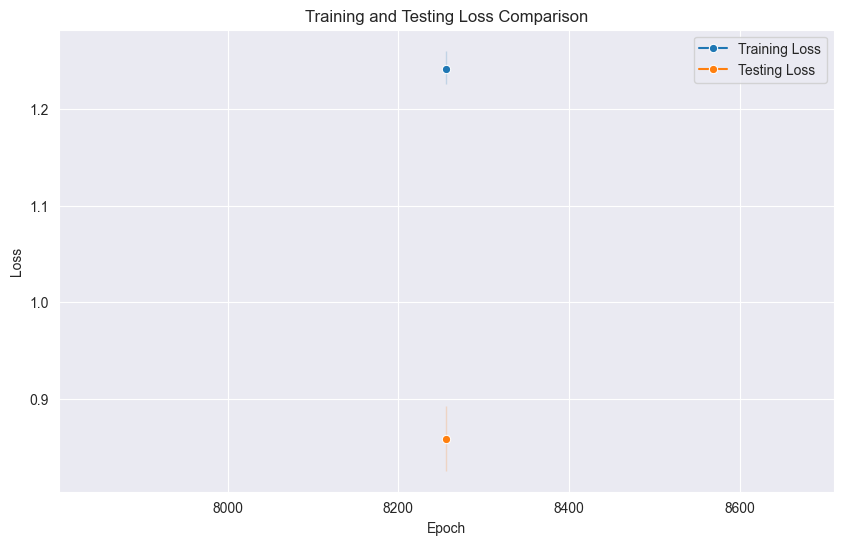

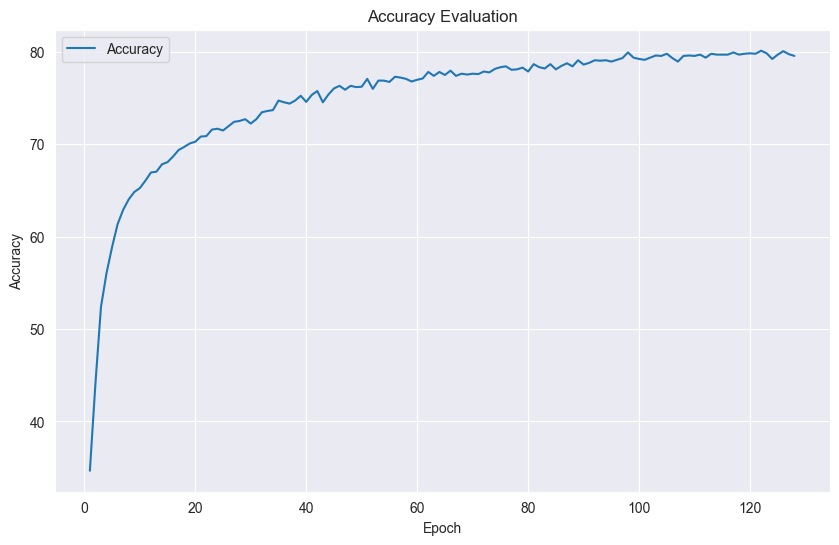

Historical data saved successfully!


In [10]:
import torch.optim as optim

hardware = torch.device('cuda' if   torch.cuda.is_available() else 'cpu')
classes = 6
learning_rate = 1e-4
weight_decay = 1e-2
num_epochs = 128

model = PestClassifierMobileNetV2(num_classes=classes).to(hardware)

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

result, accuracies = train_and_test(model=model, optimizer=optimizer, criterion=criterion,train_dataloader=train_loader, test_dataloader=test_loader, num_epoch=num_epochs, device=hardware)

plot_training_result(result=result)
plot_accuracy(result)
save_historical_data(result)

In [9]:
from PIL import Image
import torch.nn.functional as F

def predict_single_image(model, image_path, classes, transform, device):

    model.to(device)

    model.eval()

    image = Image.open(image_path).convert('RGB')

    image_np = np.array(image)

    augmented = transform(image=image_np)

    image_tensor = augmented['image'].unsqueeze(0).to(device)

    with torch.no_grad():

        result = model(image_tensor, labels=None)

        probability = F.softmax(result, dim=1)

        confidence, predicted = torch.max(probability, 1)

        predicted_class = classes[predicted.item()]
        confidence_score = confidence.item()

    return predicted_class, confidence_score


In [8]:
import torchvision.models as models

classes_names = train_set.classes

model_inference = PestClassifierMobileNetV2(num_classes=len(classes_names))
model_inference.load_state_dict(torch.load('models/SMobileNetV2_rice_pest_classification.pth', map_location=hardware))
image_path = 'datasets/test/rice-black-bug/blackbug10_jpg.rf.e8e587b5a440ddcf4f88f88de14c4618.jpg'

pest, confidence_score = predict_single_image(model=model_inference, image_path=image_path, classes=classes_names, transform=validation_pipeline, device=hardware)

print(f"The predicted pest is: {pest}")
print(f"Confidence: {confidence_score * 100:.2f}%")

120
